In [1]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD


In [2]:
from keras.initializers import Initializer
from keras.layers import Dense, Input
from keras.models import Model
from typing import List, Tuple, Union, TypeVar

KernelInitializer = TypeVar('KernelInitializer', bound=Union[str, Initializer])


def autoencoder(dims: List[int],
                activation: str = 'relu',
                initializer: KernelInitializer = 'glorot_uniform') -> Tuple[Model, Model]:
    """
    Fully connected symmetric autoencoder model.

    Args:
        dims (List[int]): List of the sizes of layers of encoder.
                          dims[0] is input dim, dims[-1] is size of the latent hidden layer.
        activation (str, optional): Activation function. Defaults to 'relu'.
        initializer (KernelInitializer, optional): Kernel initializer. Defaults to 'glorot_uniform'.

    Returns:
        Tuple[Model, Model]: Autoencoder and encoder models
    """
    n_stacks = len(dims) - 1

    input_layer = Input(shape=(dims[0], ), name='input')
    layer = input_layer

    # Encoder internal layers
    for i_layer in range(n_stacks - 1):
        layer = Dense(dims[i_layer + 1],
                      activation=activation,
                      kernel_initializer=initializer,
                      name=f"encoder_{i_layer}")(layer)

    # Latent hidden layer
    encoded_layer = Dense(dims[-1], kernel_initializer=initializer, name=f"encoder_{n_stacks - 1}")(layer)

    # Decoder internal layers
    layer = encoded_layer
    for i_layer in range(n_stacks - 1, 0, -1):
        layer = Dense(dims[i_layer], activation=activation, kernel_initializer=initializer,
                      name=f"decoder_{i_layer}")(layer)

    # Decoder output
    layer = Dense(dims[0], kernel_initializer=initializer, name='decoder_0')(layer)
    decoded_layer = layer

    _autoencoder = Model(inputs=input_layer, outputs=decoded_layer, name='autoencoder')
    _encoder = Model(inputs=input_layer, outputs=encoded_layer, name='encoder')

    return _autoencoder, _encoder


In [3]:
import keras.backend as K
from keras.layers import InputSpec, Layer


class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha: float = 1.0, **kwargs):
        """
        This layer converts the input sample to soft label, i.e. a vector that represents
        the probability of the sample belonging to each cluster.

        The probability is calculated with student's t-distribution.

        Args:
            n_clusters (int): Number of clusters.
            weights (optional): List of Numpy array with shape `(n_clusters, n_features)` which represents the initial cluster centers.
            alpha (float, optional): Degrees of freedom of the Student's t-distribution. Defaults to 1.0.

        Input shape:
            2D tensor with shape: `(n_samples, n_features)`

        Output shape:
            2D tensor with shape: `(n_samples, n_clusters)`
        """
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'), )
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform')

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """
        Student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
            q_ij = 1.0 / (1.0 + dist(x_i, µ_j)^2), then normalize it.
            q_ij can be interpreted as the probability of assingning sample i to cluster j.
            (i.e., a soft assignment)

        Reference:
            Unsupervised Deep Embedding for Clustering Analysis - 3.1.1 Soft Assignment

        Args:
            inputs: The variable containing data, shape=(n_samples, n_features)

        Returns:
            Student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q = K.pow(q, (self.alpha + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))

        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [4]:
from keras.models import Model
from keras.optimizers import Adam, Optimizer, SGD
import numpy as np
import os
from sklearn.cluster import KMeans
from typing import List, Union




class DEC(object):
    def __init__(self,
                 dims: List[int],
                 n_clusters: int,
                 activation: str = 'relu',
                 alpha: float = 1.0,
                 initializer: KernelInitializer = 'glorot_uniform'):
        """
        Unsupervised Deep Embedding for Clustering Analysis (DEC)
        Link: http://proceedings.mlr.press/v48/xieb16.pdf

        DEC learns a mapping from the data space to a lower-dimensional feature space
        in which it iteratively optimizes a clustering objective.

        Args:
            dims (List[int]): DEC layers configuration. First element must be the number of features.
            n_clusters (int): The number of clusters to be found.
            activation (str, optional): Activation function used in encoder models. Defaults to relu.
            alpha (float, optional): Degrees of freedom of the Student's t-distribution. Defaults to 1.0.
            initializer (KernelInitializer, optional): Kernel initializer used in encoder models. Defaults to glorot_uniform.
            optimizer (Optimizer, optional): Optimizer used in encoder models. Defaults to SGD.
        """
        super(DEC, self).__init__()

        self._dims = dims
        self._n_clusters = n_clusters
        self._pretrained = False

        # Autoencoder and encoder models
        self._autoencoder, self._encoder = autoencoder(dims=dims, activation=activation, initializer=initializer)

        # DEC model
        clustering_layer = ClusteringLayer(n_clusters, alpha=alpha, name='clustering')(self._encoder.output)
        self._model = Model(inputs=self._encoder.input, outputs=clustering_layer)

    @property
    def dims(self):
        return self._dims

    @property
    def n_clusters(self):
        return self._n_clusters

    @property
    def model(self):
        return self._model

    @property
    def autoencoder(self):
        return self._autoencoder

    @property
    def encoder(self):
        return self._encoder

    def load_weights(self, weights: str):
        """
        Load weights for DEC model from file

        Args:
            weights (str): The file path with saved weights
        """
        self._model.load_weights(weights)

    def extract_features(self, x):
        return self._encoder.predict(x)

    def pretrain(self,
                 x,
                 optimizer: Optimizer = Adam(),
                 loss: Union[str, List[str]] = 'mse',
                 epochs: int = 200,
                 batch_size: int = 256,
                 save_dir: str = None,
                 verbose: int = 1):
        """
        Pretrain autoencoder model.

        Args:
            x: The data used for pretraining.
            optimizer (Optimizer, optional): [description]. Defaults to Adam.
            loss (Union[str, List[str]], optional): [description]. Defaults to 'mse'.
            epochs (int, optional): The number of epochs for pretraining. Defaults to 200.
            batch_size (int, optional): The batch size for pretraining. Defaults to 256.
            save_dir (str, optional): The directory for saving autoencoder model weights. Defaults to None.
            verbose (int, optional): The verbosity level. Defaults to 0.
        """
        if verbose > 0:
            print("Pretraining autoencoder model...")
        self._autoencoder.compile(optimizer=optimizer, loss=loss)
        self._autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, verbose=verbose)
        self._pretrained = True

    def compile(self,
                optimizer: Optimizer = SGD(1, 0.9),
                loss: Union[str, List[str]] = 'kld',
                loss_weights: List[float] = None):
        """
        Compile the DEC model.

        Args:
            optimizer (Optimizer, optional): Optimizer instance. Defaults to SGD(1, 0.9).
            loss (Union[str, List[str]], optional): The loss metric to be minimized. Defaults to 'kld'.
            loss_weights (List[int], optional): Scalar coefficients to weight the loss contributions of different model outputs. Defaults to None.
        """
        self._model.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights)

    def fit(self,
            x,
            batch_size: int = 256,
            maxiter: int = 2000,
            tol: float = 1e-3,
            update_interval: int = 140,
            save_dir: str = None,
            verbose: int = 1):
        """
        Fit DEC model and give predictions for dataset `x`.

        Args:
            x: The dataset used for training and predicting.
            batch_size (int, optional): The batch size. Defaults to 256.
            maxiter (int, optional): Maximum iterations for training. Defaults to 1000.
            tol (float, optional): Tolerance threshold to stop training. Defaults to 1e-3.
            update_interval (int, optional): Number of iterations before updating internal predictions. Defaults to 140.
            save_dir (str, optional): The directory for saving dec model weights. Defaults to None.
            verbose (int, optional): The verbosity level. Defaults to 1.

        Returns:
            Array with the predicted group for each `x` sample.
        """
        if verbose > 0:
            print("Training DEC model...")

        # DEC - Phase 1: parameter initialization with a deep autoencoder
        # Reference:
        #     Unsupervised Deep Embedding for Clustering Analysis - 3.2 Parameter initialization
        kmeans = KMeans(self._n_clusters, n_init=20,init="k-means++")
        y_pred = kmeans.fit_predict(self._encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self._model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # DEC - Phase 2: Optimization
        # Reference:
        #     Unsupervised Deep Embedding for Clustering Analysis - 3.1 Clustering with KL divergence
        loss, index = 1.0, 0
        index_array, p = np.arange(x.shape[0]), []
        for it in range(maxiter):
            if it % update_interval == 0:
                if verbose > 0:
                    print(f"Iteration {it + 1}/{maxiter} - loss: {np.max(loss):.4e}")
                q = self._model.predict(x, verbose=verbose)
                p = self._target_distribution(q)
                y_pred = np.argmax(q, 1)

                # Stop criteria
                delta_label = np.sum(y_pred != y_pred_last, dtype=np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if it > 0 and delta_label < tol:
                    if verbose > 0:
                        print(f"Reached tolerance threshold: {delta_label:.4e} < {tol}. Stopping training.")
                    break

            # Train on batch
            idx = index_array[index * batch_size:min((index + 1) * batch_size, x.shape[0])]
            loss = self._model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

        self._trained = True
        if save_dir is not None:
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
            file_path = f"{save_dir}/dec_model_weights.h5"
            self._autoencoder.save_weights(file_path)
            print(f"DEC model weights have been saved to: {file_path}")

    def predict(self, x, verbose: int = 0) -> np.ndarray:
        """
        Generate predictions for the given dataset

        Args:
            x: The input data

        Returns:
            np.ndarray: Numpy array of predictions
        """
        if not self._trained:
            raise Exception("This model has not been trained yet")
        q = self._model.predict(x, verbose=verbose)
        return np.argmax(q, 1)

    @staticmethod
    def _target_distribution(q: np.ndarray) -> np.ndarray:
        """
        Kullback-Leibler (KL) divergence

        Args:
            q (np.ndarray): Model predictions

        Returns:
            np.ndarray: The computed distribution
        """
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T


In [5]:
from skimage import color
import matplotlib.pyplot as plt 
import cv2

# Read the image
image = cv2.imread("alger.jpg")

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert RGB to L*a*b*
image_lab = color.rgb2lab(image_rgb)

# Access L*, a*, and b* channels
L, a, b = cv2.split(image_lab)
# Reshape the image data to a 2D array for deep embedded clustering
x = image_lab.reshape((-1, 3))
x=x/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


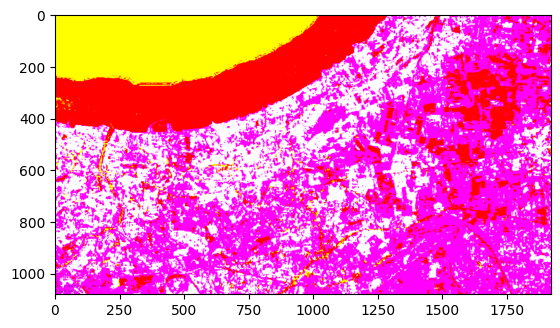

In [6]:
plt.imshow(image_lab)

In [7]:
dims = [x.shape[-1], 500, 500, 2000, 3]

loss = 'mse'
init = 'glorot_uniform'
optimizer = SGD(0.001, 0.9)

init = VarianceScaling(scale=1./3., mode='fan_in', distribution='uniform')
# DEC model
dec = DEC(dims=dims, n_clusters=4, initializer=init)
dec.compile(optimizer=optimizer, loss=loss)
dec.model.summary()

c:\Users\kessa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 encoder_0 (Dense)           (None, 500)               2000      
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 3)                 6003      
                                                                 
 clustering (ClusteringLaye  (None, 4)                 12        
 r)                                                              
                                                             

In [8]:
pretrain_epochs = 10
batch_size = 256
maxiter = 2000
update_interval = 140
verbose = 1
pretrain_optimizer = 'adam'
dec.pretrain(x, optimizer=pretrain_optimizer, epochs=pretrain_epochs, batch_size=batch_size)
dec.fit(x, batch_size=batch_size, maxiter=maxiter, update_interval=update_interval, verbose=verbose)

Pretraining autoencoder model...

Epoch 1/10

8100/8100 [==============================] - 1002s 116ms/step - loss: 1.1139e-05
Epoch 2/10
8100/8100 [==============================] - 992s 122ms/step - loss: 5.7279e-07
Epoch 3/10
8100/8100 [==============================] - 990s 122ms/step - loss: 3.6941e-07
Epoch 4/10
8100/8100 [==============================] - 992s 122ms/step - loss: 2.7580e-07
Epoch 5/10
8100/8100 [==============================] - 991s 122ms/step - loss: 2.1465e-07
Epoch 6/10
8100/8100 [==============================] - 979s 121ms/step - loss: 1.9072e-07
Epoch 7/10
8100/8100 [==============================] - 945s 117ms/step - loss: 1.6853e-07
Epoch 8/10
8100/8100 [==============================] - 934s 115ms/step - loss: 1.5187e-07
Epoch 9/10
8100/8100 [==============================] - 925s 114ms/step - loss: 1.3959e-07
Epoch 10/10
8100/8100 [==============================] - 772s 95ms/step - loss: 1.3821e-07
Training DEC model...
64800/64800 [===================

In [9]:
y_pred=dec.predict(x)

In [10]:
segmented_image=y_pred.reshape(image.shape[:2])

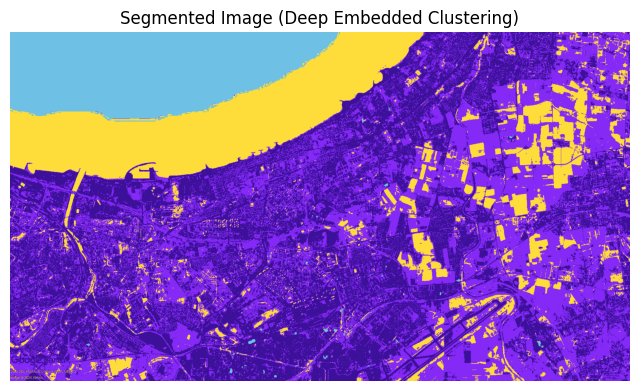

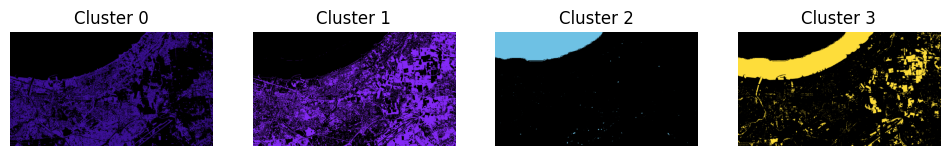

In [11]:
import numpy as np
# Define colors for each label
label_colors = {
        0: (60, 16, 152), # Deep Purple
        1: (132, 41, 246), # Lavender
        2: (110, 193, 228), # Sky Blue
        3: (254, 221, 58) ,# Sunflower Yellow
        4: (226, 169, 41), # Amber
        5: (155, 155, 155), # Dim Gray
        6: (32, 178, 170), #Turquoise
        7: (255, 105, 180), #Hot Pink
        8: (128, 0, 128) ,#Purple
        9: (255, 140, 0), #Orange
        10: (0, 128, 0) #Green
    }

# Create a mask for each unique value and apply the color
colored_mask = np.zeros(segmented_image.shape + (3,), dtype=np.uint8)
for label, rgb_color in label_colors.items():
    colored_mask[segmented_image == label] = rgb_color

# Display the segmented image
plt.figure(figsize=(8, 8))
plt.imshow(colored_mask)
plt.title('Segmented Image (Deep Embedded Clustering)')
plt.axis('off')
plt.show()

# Identify unique labels in the segmented image
unique_labels = set(y_pred)
# Create and display masks for each label
plt.figure(figsize=(12, 4))
for i, label in enumerate(unique_labels):
    # Create a mask for the current label
    mask = np.zeros(segmented_image.shape + (3,), dtype=np.uint8)  # Create a mask with 3 channels
    mask[segmented_image == label] = label_colors[label]  # Assign color to each channel separately
    # Display the mask
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(mask)
    plt.title(f'Cluster {label}')
    plt.axis('off')

In [12]:
from sklearn.metrics import davies_bouldin_score
# Calculating Davies-Bouldin index
db_index = davies_bouldin_score(x,y_pred)
print(f'Davies-Bouldin index for  clusters : ', db_index)

Davies-Bouldin index for  clusters :  0.6018146464851515
